<a href="https://colab.research.google.com/github/albim72/MLDL_001/blob/main/rezcenzje_filmow_sentymenty_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1",url,untar=True,cache_dir='.',cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset),'aclImdb')

84125825/84125825 [==============================] - 4s 0us/step


In [3]:
os.listdir(dataset_dir)

['test', 'train', 'imdbEr.txt', 'imdb.vocab', 'README']

In [4]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['unsupBow.feat',
 'unsup',
 'pos',
 'urls_pos.txt',
 'neg',
 'labeledBow.feat',
 'urls_unsup.txt',
 'urls_neg.txt']

In [5]:
sample_file = os.path.join(train_dir,'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [8]:
remove_dir = os.path.join(train_dir,'unsup')
shutil.rmtree(remove_dir)

FileNotFoundError: [Errno 2] No such file or directory: './aclImdb/train/unsup'

In [7]:
os.listdir(train_dir)

['unsupBow.feat',
 'pos',
 'urls_pos.txt',
 'neg',
 'labeledBow.feat',
 'urls_unsup.txt',
 'urls_neg.txt']

In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset='training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [11]:
for text_batch,label_batch in raw_train_ds.take(1):
  for i in range(3):
    print(f"Recenzja: {text_batch.numpy()[i]}")
    print(f"Etykieta: {label_batch.numpy()[i]}")

Recenzja: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Etykieta: 0
Recenzja: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [12]:
print(f"Label 0: {raw_train_ds.class_names[0]}")
print(f"Label 1: {raw_train_ds.class_names[1]}")

Label 0: neg
Label 1: pos


In [14]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [15]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size = batch_size

)

Found 25000 files belonging to 2 classes.


In [26]:
#Przygotowanie zbioru danych do szkolenia
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase,'<br />',' ')
  return tf.strings.regex_replace(stripped_html,'[%s]' %re.escape(string.punctuation),'')

In [27]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

In [28]:
train_text = raw_train_ds.map(lambda x,y:x)
vectorize_layer.adapt(train_text)

In [30]:
def vectorize_text(text,label):
  text=tf.expand_dims(text,-1)
  return vectorize_layer(text), label

In [32]:
text_batch,label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print(f"Recenzja: {first_review}")
print(f"Etykieta: {raw_train_ds.class_names[first_label]}")
print(f"Widok zwektoryzowany: {vectorize_text(first_review,first_label)}")

Recenzja: b'If you want Scream or anything like the big-studio horror product that we get forced on us these days don\'t bother. This well-written film kept me up thinking about all it had to say. Importance of myth in our lives to make it make sense, how children interpret the world (and the violence in it), our ransacking of the environment and ignorance of its history and legends.. all here, but not flatly on the surface. You could technically call it a "monster movie" even though the Wendigo does not take physical form until the end, and then it\'s even up to you and your beliefs as to what\'s happening with the legendary spirit/beast. Some standard thriller elements for those looking just for the basics and the film never bores, though in fact the less you see of the creature, the better. Fessenden successfully continues George Romero\'s tradition of using the genre as parable and as a discussion forum while still keeping us creeped out.'
Etykieta: pos
Widok zwektoryzowany: (<tf.T

In [35]:
print(f"9 --> {vectorize_layer.get_vocabulary()[9]}")
print(f"1 --> {vectorize_layer.get_vocabulary()[1]}")
print(f"1287 --> {vectorize_layer.get_vocabulary()[1287]}")
print(f"313 --> {vectorize_layer.get_vocabulary()[313]}")

9 --> it
1 --> [UNK]
1287 --> silent
313 --> night


In [36]:
print(f"Rozmiar słownika: {len(vectorize_layer.get_vocabulary())}")

Rozmiar słownika: 10000


In [39]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [40]:
#konfiguracja zbiorów danych pod kątem wydajności
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [43]:
#stowrzenie modelu sieci neuronowej
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features+1,embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [45]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [63]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 6s 10ms/step - loss: 0.2048 - binary_accuracy: 0.9273 - val_loss: 0.2872 - val_binary_accuracy: 0.8814
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.1936 - binary_accuracy: 0.9311 - val_loss: 0.2863 - val_binary_accuracy: 0.8822
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.1850 - binary_accuracy: 0.9355 - val_loss: 0.2867 - val_binary_accuracy: 0.8830
Epoch 4/10
625/625 [==============================] - 6s 10ms/step - loss: 0.1760 - binary_accuracy: 0.9405 - val_loss: 0.2876 - val_binary_accuracy: 0.8838
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.1683 - binary_accuracy: 0.9424 - val_loss: 0.2897 - val_binary_accuracy: 0.8842
Epoch 6/10
625/625 [==============================] - 6s 10ms/step - loss: 0.1601 - binary_accuracy: 0.9452 - val_loss: 0.2918 - val_binary_accuracy: 0.8844
Epoch 7/10
625/625 [==============================] - 5s 8ms/

In [64]:
#ocena modelu
loss,accuracy = model.evaluate(test_ds)

print(f"strata: {loss}")
print(f"dokładność: {accuracy}")

782/782 [==============================] - 1s 2ms/step - loss: 0.3432 - binary_accuracy: 0.8662
strata: 0.34317928552627563
dokładność: 0.8662400245666504


In [65]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

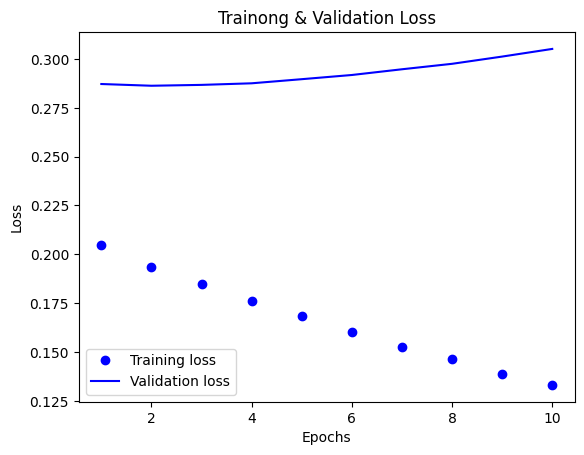

In [66]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Trainong & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

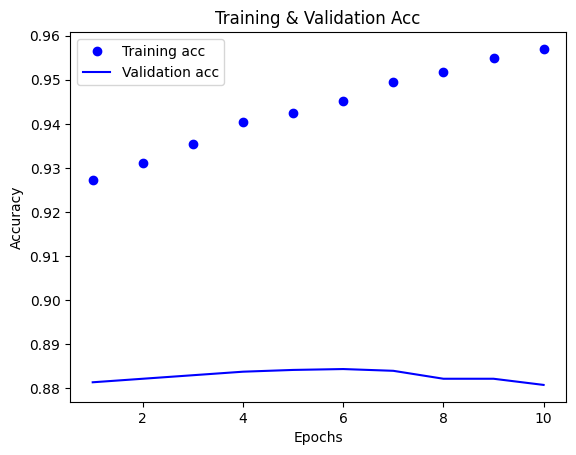

In [67]:
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training & Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [68]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy']
)

loss,accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 5s 6ms/step - loss: 0.3432 - accuracy: 0.8662
0.8662400245666504


In [69]:
przyklady = ["The movie was great!",
             "The movie was okey.",
             "The movie was terrible!",
             "Very bad",
             "Beautiful",
             "Disaster",
             "Beautiful Disaster",
             "Shit!",
             "Zły film"

]

export_model.predict(przyklady)

1/1 [==============================] - 0s 114ms/step


array([[0.6525231 ],
       [0.51050305],
       [0.28994995],
       [0.39263666],
       [0.67094886],
       [0.4424059 ],
       [0.5870772 ],
       [0.5287933 ],
       [0.5377346 ]], dtype=float32)